In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import auc,roc_curve,accuracy_score,precision_score,recall_score,confusion_matrix,precision_recall_curve,roc_auc_score
from mlflow.exceptions import MlflowException


In [122]:
import pickle
import mlflow
import logging
import mlflow.sklearn

In [123]:
df = pd.read_csv("winequality-red.csv")

In [124]:
df.shape

(1599, 12)

In [125]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [126]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [127]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3])

In [128]:
# As it is multi class classification problem. so just to test the other things
# we are making it a binary classification problem

df['quality'] = np.where(df['quality'].isin([5, 6, 7]), 1, 0)
print(df['quality'].unique())

[1 0]


In [129]:
X = df.drop(['quality'],axis=1)
y = df['quality']

In [130]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=34)
print(Xtrain.shape,Xtest.shape,ytrain.shape,ytest.shape)

(1279, 11) (320, 11) (1279,) (320,)


In [131]:
clf = DecisionTreeClassifier()
clf.fit(Xtrain,ytrain)

DecisionTreeClassifier()

In [132]:
ypred = clf.predict(Xtest)

In [133]:
# Metrics
accuracy = accuracy_score(ytest,ypred)
recall = recall_score(ytest,ypred,average='macro')
precision = precision_score(ytest,ypred,average='micro')
con_mat = confusion_matrix(ytest,ypred)

In [134]:
print("Accuracy : ",accuracy)
print("Recall : ",recall)
print("Precision : ",precision)
print("con_mat : ",con_mat)

Accuracy :  0.9125
Recall :  0.569078947368421
Precision :  0.9125
con_mat :  [[  3  13]
 [ 15 289]]


In [135]:
# Saving the 'con_mat' as the text file to log with mlflow
with open('Confusion_matrix.txt','w') as f:
    f.write('Confusion Matrix :')
    f.write(str(con_mat))

In [136]:
# For plotting the auc_roc curve
pred_prob = clf.predict_proba(Xtest)
## roc curve for model
fpr,tpr,threshold = roc_curve(ytest,pred_prob[:,1],pos_label=1)

## roc curve for tpr = fpr
random_probs = [0 for i in range(len(ytest))]
p_fpr,p_tpr ,_ = roc_curve(ytest,random_probs,pos_label=1)



In [137]:
fpr

array([0.    , 0.8125, 1.    ])

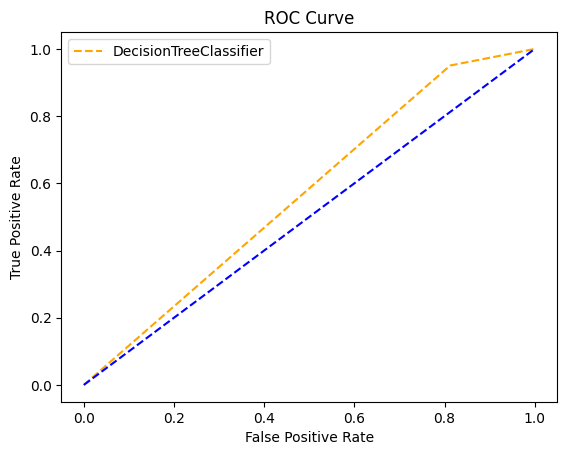

In [138]:
## Plotting the graphs
plt.plot(fpr, tpr, linestyle='--', color='orange', label='DecisionTreeClassifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.savefig('Roc')
plt.show()

In [139]:
type(Xtrain)

pandas.core.frame.DataFrame

In [140]:
# Logging the dataset
Xtrain.to_csv("X_train.csv", index=False)
ytrain.to_csv("y_train.csv", index=False)
Xtest.to_csv("X_test.csv", index=False)
ytest.to_csv("y_test.csv", index=False)

## Single predicition

In [141]:
# predicting for individual values
single_prediction  = clf.predict([[7.5, 0.65, 0.12, 2.1, 0.085, 12.0, 45.0, 0.9975, 3.35, 0.60, 10.2]])
single_prediction

/Users/ravikantkumar/anaconda3/envs/test_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([1])

In [142]:
# Creating pickle
with open('model.pkl','wb') as file:
    pickle.dump(clf,file)

## Mlflow

In [143]:
import mlflow

# Set the MLflow tracking URI programmatically
mlflow.set_tracking_uri('/Users/ravikantkumar/myspace/model_testing/mlruns')


In [144]:
# Creating experiment
# defining a function for checking the experiment first and if not found the creating one.
def get_or_create_experiment(name):
    """
    Get an existing MLflow experiment ID with the given name or create a new one if it does not exist,
    with exception handling to manage potential errors gracefully.

    :param name: str, name of the experiment
    :return: str, experiment ID or None if an error occurs
    """
    try:
        experiment = mlflow.get_experiment_by_name(name)

        if experiment:
            print(f"Experiment with name '{name}' already exists with ID {experiment.experiment_id}")
            return experiment.experiment_id
        else:
            # Create a new experiment if it does not exist
            experiment_id = mlflow.create_experiment(name)
            print(f"Created new experiment with name '{name}' and ID {experiment_id}")
            return experiment_id
    except MlflowException as e:
        print(f"An error occurred while accessing MLflow: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None


# Above code two exceptions have been defined to capture the more details 

In [145]:
# Definig experiement name
experiment_name = "Wine Quality classification Experiment"

**Order in which arguments are passed in the logging parameters.** <br>
<br>
Models: Pass the model object and the model’s artifact path name.
Ex : mlflow.sklearn.log_model(clf, "Classification-Model")

Metrics: Pass the metric name and value.
Ex :  mlflow.log_metric("Accuracy", accuracy)

Artifacts: Pass the file path and optionally the artifact directory name.
Ex:  mlflow.log_artifact("Roc.png", "Roc")

In [146]:
# Defining function for linking the experiment  with run
def start_experiment_run(name):
    experiment_id = get_or_create_experiment(experiment_name)
    # logging.getLogger("mlflow.utils.environment").setLevel(logging.DEBUG)

    # Defining the tags for mlflow run
    tags = {
        'model_type' : 'DecisionTreeClassifier',
        'Version_run' : 4,
        'Author': 'Rkk'
    }

    if experiment_id is not None:

        # set the experiment
        # mlflow.set_experiment(experiment_id)
        mlflow.set_experiment(experiment_name)

        # start mlflow run
        with mlflow.start_run() as run:
            mlflow.set_tags(tags)
            mlflow.sklearn.log_model(clf,"Classification-Model")
            mlflow.log_metric("Accuracy",accuracy)
            mlflow.log_metric("Recall",recall)
            mlflow.log_metric("Precision",precision)
            # Logging image and confusion matrix
            mlflow.log_artifact("Roc.png", "Roc")
            mlflow.log_artifact('Confusion_matrix.txt',"Confusion_matrix")
            # Log the CSV files as artifacts
            mlflow.log_artifact("X_train.csv", "training_data_features")
            mlflow.log_artifact("y_train.csv", "training_data_target")
            mlflow.log_artifact("X_test.csv", "test_data_features")
            mlflow.log_artifact("y_test.csv","test_data_target")
    else:
        print("Failed to start the mlflow run due to experiment creation or retrieval")

In [147]:
start_experiment_run(experiment_name)

Experiment with name 'Wine Quality classification Experiment' already exists with ID 179020510512775425
